In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score


In [2]:
spx_px = pd.read_excel(r'idx_prices.xlsx', sheet_name='SPX_INDEX')
bcom_px = pd.read_excel(r'idx_prices.xlsx', sheet_name='BCOM_INDEX')
lactruu_px = pd.read_excel(r'idx_prices.xlsx', sheet_name='LUACTRUU_INDEX')



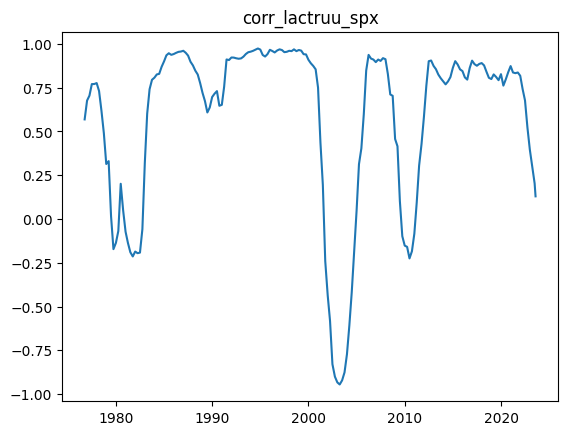

In [17]:
corr_lactruu_spx = lactruu_px['Last Price'].rolling(15).corr(spx_px['Last Price']) 
corr_lactruu_spx.dropna(inplace=True)
plt.plot(lactruu_px['Date'].values[:-14], corr_lactruu_spx)
plt.title('corr_lactruu_spx')
plt.savefig('figures/corr_lactruu_spx.png')
plt.show()


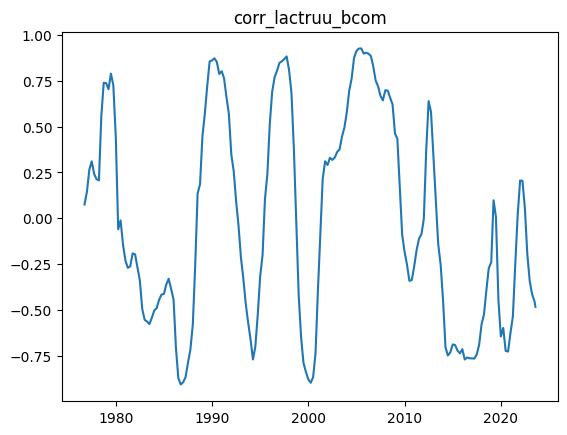

In [18]:
corr_lactruu_bcom = lactruu_px['Last Price'].rolling(15).corr(bcom_px['Last Price']) 
corr_lactruu_bcom.dropna(inplace=True)
plt.plot(lactruu_px['Date'][:-14], corr_lactruu_bcom)
plt.title('corr_lactruu_bcom')
plt.savefig('figures/corr_lactruu_bcom.png')
plt.show()

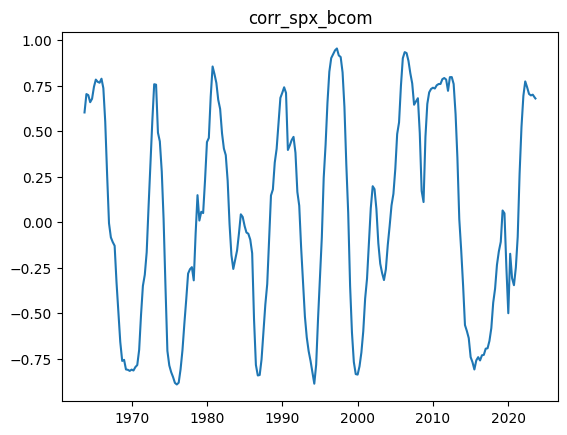

In [19]:
corr_spx_bcom = spx_px['Last Price'].rolling(15).corr(bcom_px['Last Price']) 
corr_spx_bcom.dropna(inplace=True)
plt.plot(bcom_px['Date'][:-14], corr_spx_bcom)
plt.title('corr_spx_bcom')
plt.savefig('figures/corr_spx_bcom.png')
plt.show()

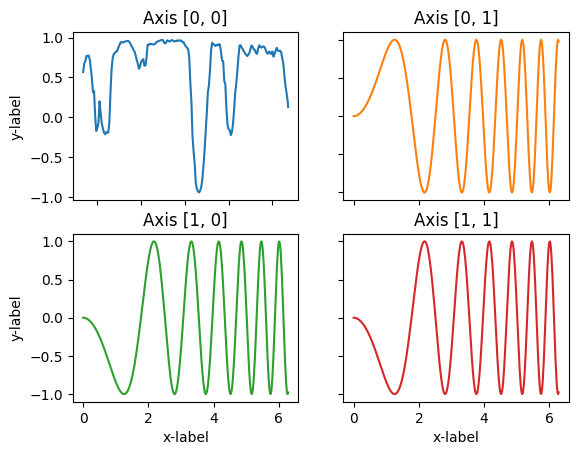

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

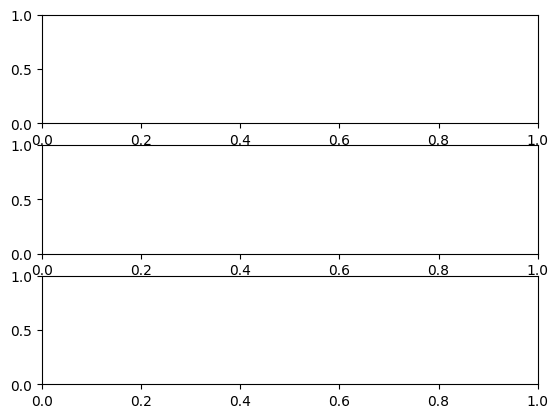

In [36]:


fig, axs = plt.subplots(3, 1)
axs[0,0].plot(lactruu_px['Date'].values[:-14], corr_lactruu_spx)
axs[0,0].set_title('corr_lactruu_spx')

axs[1,0].plot(lactruu_px['Date'].values[:-14], corr_lactruu_spx)
axs[1,0].set_title('corr_lactruu_spx')

axs[2,0].plot(lactruu_px['Date'].values[:-14], corr_lactruu_spx)
axs[2,0].set_title('corr_lactruu_spx')




In [6]:
TEST_FOLD = 1/3
TRAIN_FOLD = 2/3
WINDOW_LENGTH = 5

from sklearn import linear_model
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon
from utils import converter

results = []

In [7]:
def lasso_dc_model(corr_ts):
    num_train = int(len(corr_ts)* TRAIN_FOLD)
    num_test = len(corr_ts) - num_train

    y_train_corr = corr_ts[0:num_train]
    y_test_corr = corr_ts[num_train:]

    fh_lasso = ForecastingHorizon(np.arange(1,num_test+1))
    forecaster_lasso = make_reduction(linear_model.Lasso(), window_length=WINDOW_LENGTH, strategy="recursive")
    forecaster_lasso.fit(y_train_corr, fh=fh_lasso)

    lasso_predictions = forecaster_lasso.predict()

    lasso_predictions_dc = converter(y_train_corr, lasso_predictions)
    lasso_true_dc = converter(y_train_corr, y_test_corr)

    return accuracy_score(lasso_true_dc, lasso_predictions_dc)

results.append( ('lasso_dc_model', 'corr_lactruu_spx', lasso_dc_model(corr_lactruu_spx)))
results.append( ('lasso_dc_model', 'corr_lactruu_bcom', lasso_dc_model(corr_lactruu_bcom)))
results.append( ('lasso_dc_model', 'corr_spx_bcom', lasso_dc_model(corr_spx_bcom)))



In [8]:
from sktime.forecasting.model_selection import SlidingWindowSplitter
from hmmlearn import hmm
from sklearn.ensemble import RandomForestRegressor

def expgenous_dc_model(corr_ts):
    exogenous_model=hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000)

    num_train = int(len(corr_ts)* TRAIN_FOLD)
    num_test = len(corr_ts) - num_train

    y_train_corr = corr_ts[0:num_train]
    y_test_corr = corr_ts[num_train:]


    y = y_train_corr.values.reshape(-1,1)
    exogenous_model.fit(y)
    decoded_y = exogenous_model.decode(y)[1]
    X_train  = pd.Series(index = y_train_corr.index, data = decoded_y)
    fh = ForecastingHorizon(np.arange(1,len(y_test_corr)+1))
    forecaster_rf = make_reduction(RandomForestRegressor(), window_length=WINDOW_LENGTH, strategy="recursive")
    forecaster_rf.fit(X = X_train,y=y_train_corr, fh=fh)


    comb_y = pd.concat([y_train_corr, y_test_corr])
    predictions = []
    splitter = SlidingWindowSplitter(fh=[1], window_length=y_train_corr.shape[0])
    for split in splitter.split(comb_y):
        y = comb_y.iloc[split[0]].values.reshape(-1,1)
        exogenous_model.fit(y)
        predictions.append(exogenous_model.decode(y)[1][-1])

    X_pred = pd.Series(index=y_test_corr.index,data=predictions)
    y_pred = forecaster_rf.predict(X=X_pred)

    forecaster_rf_predictions_dc = converter(y_train_corr, y_pred)
    forecaster_rf_true_dc = converter(y_train_corr, y_test_corr)
    return accuracy_score(forecaster_rf_true_dc, forecaster_rf_predictions_dc)

results.append( ('expgenous_dc_model', 'corr_lactruu_spx', expgenous_dc_model(corr_lactruu_spx)))
results.append( ('expgenous_dc_model', 'corr_lactruu_bcom', expgenous_dc_model(corr_lactruu_bcom)))
results.append( ('expgenous_dc_model', 'corr_spx_bcom', expgenous_dc_model(corr_spx_bcom)))



Model is not converging.  Current: 76.19070437287527 is not greater than 76.19087565094662. Delta is -0.0001712780713489792
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


In [20]:
result_df = pd.DataFrame(columns=['model','ts','accuracy'], data= results)
result_df.sort_values(by='accuracy', ascending=False).to_latex(buf='latex/dc_df_results.tex', index=False)